In [1]:
import pandas as pd
import pm4py

from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.statistics.traces.generic.log import case_statistics

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Data Import:
xes_path = "/Users/moritz_hawener/Documents/Work/Studium/Master/WS25/BPI/BPI Challenge 2017_1_all/BPI Challenge 2017.xes.gz"

# Read the XES log
event_log = xes_importer.apply(xes_path)

/opt/miniconda3/envs/bpi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 31509/31509 [00:31<00:00, 995.02it/s] 


In [3]:
# Transform the event log to a pandas DataFrame
df = log_converter.apply(event_log, variant=log_converter.Variants.TO_DATA_FRAME)

### CONCEPT DRIFT

In [4]:
# Extract case-level features for drift analysis
def extract_case_features(df):
    # aggregated features per case
    case_features = df.groupby('case:concept:name').agg({
        'time:timestamp': ['min', 'max', 'count'],
        'concept:name': lambda x: len(x.unique()),
        'org:resource': lambda x: len(x.unique()),
        'case:RequestedAmount': 'first',
        'case:LoanGoal': 'first',
        'case:ApplicationType': 'first'
    }).reset_index()
    
    case_features.columns = ['case:concept:name', 'start_time', 'end_time', 'num_events', 
                             'num_unique_activities', 'num_unique_resources',
                             'case:RequestedAmount', 'case:LoanGoal', 'case:ApplicationType']
    
    # Calculate throughput time in days
    case_features['throughput_days'] = (
        case_features['end_time'] - case_features['start_time']
    ).dt.total_seconds() / (24 * 3600)
    
    # Determine outcome based on 'Accepted' column
    # Get final status per case
    accepted_status = df.groupby('case:concept:name')['Accepted'].apply(
        lambda x: x.dropna().iloc[-1] if x.dropna().shape[0] > 0 else 'Unknown'
    ).reset_index()
    accepted_status.columns = ['case:concept:name', 'accepted_status']
    
    case_features = case_features.merge(accepted_status, on='case:concept:name', how='left')
    
    # Map to outcome (the 'Accepted' field contains 'true' or 'false' as strings)
    case_features['outcome'] = case_features['accepted_status'].apply(
        lambda x: 'Approved' if str(x).lower() == 'true' 
        else 'Rejected' if str(x).lower() == 'false'
        else 'Cancelled'  # Cases that were cancelled before offer acceptance
    )
    
    # Get offer details if available
    offer_data = df[df['OfferedAmount'].notna()].groupby('case:concept:name').agg({
        'OfferedAmount': 'first',
        'CreditScore': 'first',
        'MonthlyCost': 'first',
        'NumberOfTerms': 'first'
    }).reset_index()
    
    case_features = case_features.merge(offer_data, on='case:concept:name', how='left')
    
    return case_features

case_features = extract_case_features(df)
print(case_features.head())

        case:concept:name                       start_time  \
0  Application_1000086665 2016-08-03 15:57:21.673000+00:00   
1  Application_1000158214 2016-06-02 10:14:26.844000+00:00   
2  Application_1000311556 2016-04-04 15:56:37.675000+00:00   
3  Application_1000334415 2016-09-15 16:39:17.758000+00:00   
4  Application_1000339879 2016-03-17 12:57:10.159000+00:00   

                          end_time  num_events  num_unique_activities  \
0 2016-09-05 06:00:36.893000+00:00          22                     13   
1 2016-06-10 11:02:01.282000+00:00          25                     16   
2 2016-05-05 06:00:48.963000+00:00          18                     11   
3 2016-09-29 07:45:34.389000+00:00          40                     18   
4 2016-03-30 09:11:48.600000+00:00          51                     18   

   num_unique_resources  case:RequestedAmount           case:LoanGoal  \
0                     4                5000.0  Other, see explanation   
1                     4               1250

In [5]:
# time series window month
case_features['month'] = case_features['start_time'].dt.to_period('M')
case_features['week'] = case_features['start_time'].dt.to_period('W')

# approval rate per time window
monthly_stats = case_features.groupby('month').agg({
    'case:concept:name': 'count',
    'outcome': lambda x: (x == 'Approved').sum() / len(x) if len(x) > 0 else 0,
    'throughput_days': 'mean',
    'num_events': 'mean',
    'case:RequestedAmount': 'mean'
}).reset_index()

monthly_stats.columns = ['month', 'num_cases', 'approval_rate', 
                         'avg_throughput', 'avg_events', 'avg_requested_amount']
monthly_stats['month'] = monthly_stats['month'].astype(str)

print(monthly_stats)

      month  num_cases  approval_rate  avg_throughput  avg_events  \
0   2016-01       2194       0.681860       22.426142   39.901094   
1   2016-02       2412       0.708541       20.896398   37.924959   
2   2016-03       2454       0.699674       20.481046   37.389976   
3   2016-04       2177       0.698209       22.084697   38.822232   
4   2016-05       2068       0.713733       21.353022   41.041103   
5   2016-06       3001       0.731756       22.810978   39.713429   
6   2016-07       3039       0.728529       22.713891   37.485357   
7   2016-08       3085       0.737439       23.192437   36.765316   
8   2016-09       3042       0.733399       22.943594   36.512163   
9   2016-10       2995       0.733556       21.492737   37.122204   
10  2016-11       2676       0.736921       21.496567   38.411435   
11  2016-12       2366       0.713018       19.953838   38.269653   

    avg_requested_amount  
0           15531.392434  
1           14286.043532  
2           14415.803

/var/folders/rz/nvdgk3v95fxdx4m351hjk33w0000gn/T/ipykernel_41496/1974080515.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  case_features['month'] = case_features['start_time'].dt.to_period('M')
/var/folders/rz/nvdgk3v95fxdx4m351hjk33w0000gn/T/ipykernel_41496/1974080515.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  case_features['week'] = case_features['start_time'].dt.to_period('W')


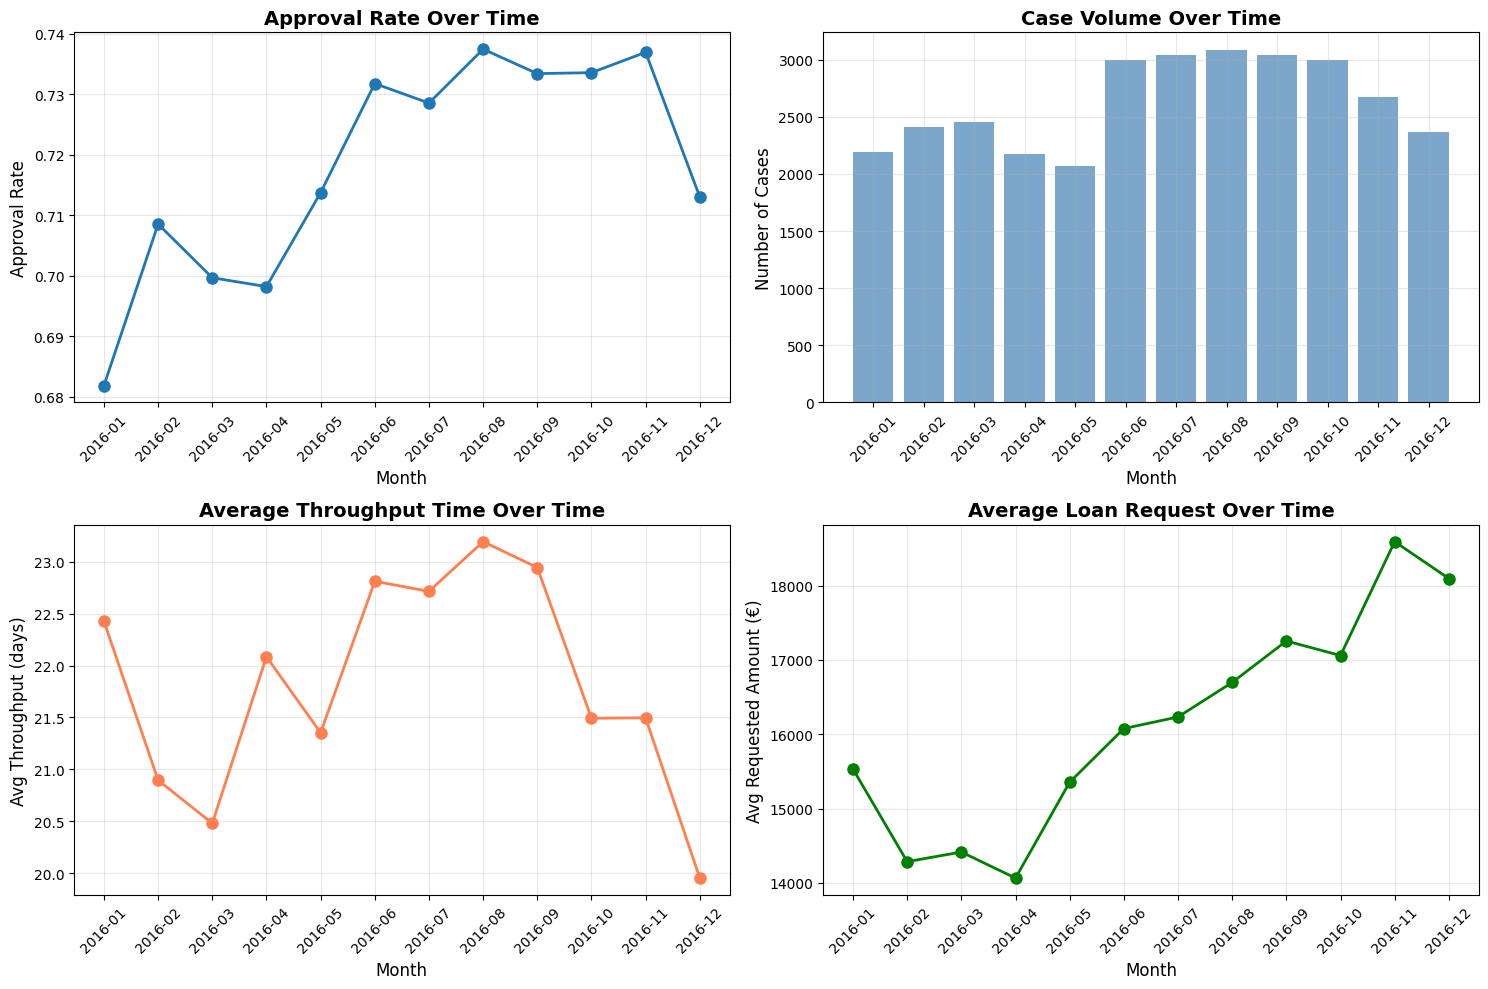

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Approval rate over time
axes[0, 0].plot(monthly_stats['month'], monthly_stats['approval_rate'], 
                marker='o', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Month', fontsize=12)
axes[0, 0].set_ylabel('Approval Rate', fontsize=12)
axes[0, 0].set_title('Approval Rate Over Time', fontsize=14, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# Case volume over time
axes[0, 1].bar(monthly_stats['month'], monthly_stats['num_cases'], 
               alpha=0.7, color='steelblue')
axes[0, 1].set_xlabel('Month', fontsize=12)
axes[0, 1].set_ylabel('Number of Cases', fontsize=12)
axes[0, 1].set_title('Case Volume Over Time', fontsize=14, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Average throughput time
axes[1, 0].plot(monthly_stats['month'], monthly_stats['avg_throughput'], 
                marker='o', linewidth=2, markersize=8, color='coral')
axes[1, 0].set_xlabel('Month', fontsize=12)
axes[1, 0].set_ylabel('Avg Throughput (days)', fontsize=12)
axes[1, 0].set_title('Average Throughput Time Over Time', fontsize=14, fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# P Average requested amount
axes[1, 1].plot(monthly_stats['month'], monthly_stats['avg_requested_amount'], 
                marker='o', linewidth=2, markersize=8, color='green')
axes[1, 1].set_xlabel('Month', fontsize=12)
axes[1, 1].set_ylabel('Avg Requested Amount (€)', fontsize=12)
axes[1, 1].set_title('Average Loan Request Over Time', fontsize=14, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
# Snippet 7: Statistical drift detection - KS test (SAME)
from scipy.stats import ks_2samp

# Compare consecutive time periods
monthly_list = sorted(case_features['month'].unique())
drift_results = []

for i in range(len(monthly_list) - 1):
    period1 = case_features[case_features['month'] == monthly_list[i]]
    period2 = case_features[case_features['month'] == monthly_list[i + 1]]
    
    # KS test on throughput time
    ks_stat, p_value = ks_2samp(period1['throughput_days'], 
                                 period2['throughput_days'])
    
    # Approval rate difference
    approval_diff = (period2['outcome'] == 'Approved').mean() - \
                   (period1['outcome'] == 'Approved').mean()
    
    drift_results.append({
        'period_from': str(monthly_list[i]),
        'period_to': str(monthly_list[i + 1]),
        'ks_statistic': ks_stat,
        'p_value': p_value,
        'significant_drift': p_value < 0.05,
        'approval_rate_change': approval_diff
    })

drift_df = pd.DataFrame(drift_results)
print("\nDrift Detection Results:")
print(drift_df)
print(f"\nPeriods with significant drift (p < 0.05): {drift_df['significant_drift'].sum()}")


Drift Detection Results:
   period_from period_to  ks_statistic       p_value  significant_drift  \
0      2016-01   2016-02      0.095632  1.333471e-09               True   
1      2016-02   2016-03      0.054152  1.512330e-03               True   
2      2016-03   2016-04      0.055925  1.394773e-03               True   
3      2016-04   2016-05      0.071602  3.520722e-05               True   
4      2016-05   2016-06      0.094613  5.417380e-10               True   
5      2016-06   2016-07      0.023526  3.653643e-01              False   
6      2016-07   2016-08      0.043783  5.414724e-03               True   
7      2016-08   2016-09      0.052312  4.341736e-04               True   
8      2016-09   2016-10      0.099518  1.812197e-13               True   
9      2016-10   2016-11      0.019566  6.415761e-01              False   
10     2016-11   2016-12      0.075962  9.401883e-07               True   

    approval_rate_change  
0               0.026681  
1              -0.0

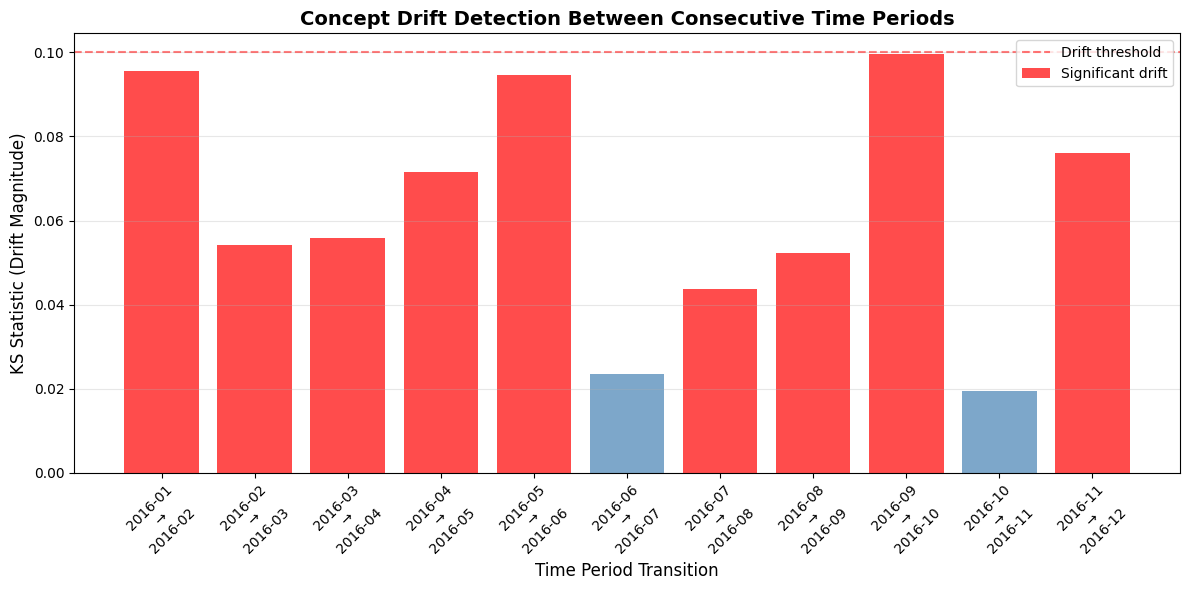

In [8]:
# Visualize KS 
fig, ax = plt.subplots(figsize=(12, 6))

x_pos = range(len(drift_df))
colors = ['red' if sig else 'steelblue' for sig in drift_df['significant_drift']]

bars = ax.bar(x_pos, drift_df['ks_statistic'], color=colors, alpha=0.7)
ax.axhline(y=0.1, color='r', linestyle='--', label='Typical threshold (0.1)', alpha=0.5)

ax.set_xlabel('Time Period Transition', fontsize=12)
ax.set_ylabel('KS Statistic (Drift Magnitude)', fontsize=12)
ax.set_title('Concept Drift Detection Between Consecutive Time Periods', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([f"{r['period_from']}\n→\n{r['period_to']}" 
                     for _, r in drift_df.iterrows()], rotation=45)
ax.legend(['Drift threshold', 'Significant drift', 'No significant drift'])
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

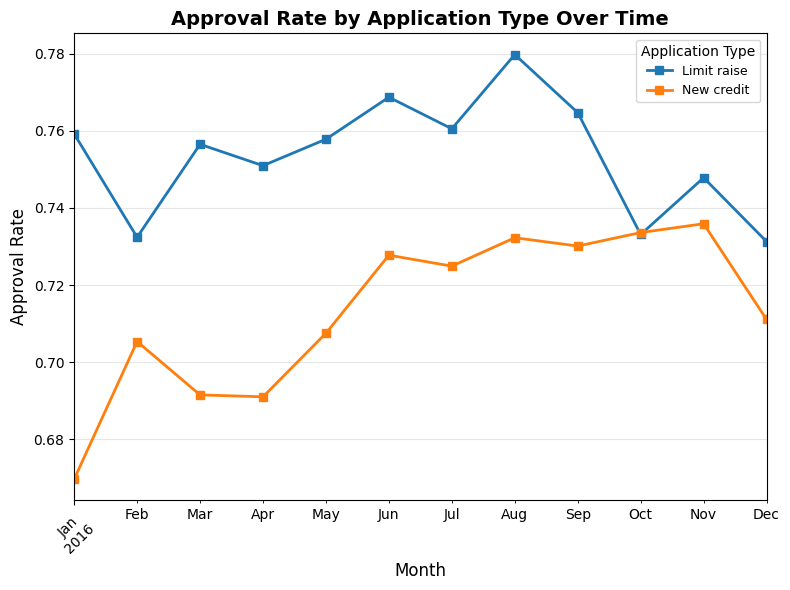

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

approval_by_type = case_features.groupby(['month', 'case:ApplicationType'])['outcome'].apply(
    lambda x: (x == 'Approved').mean()
).unstack()

approval_by_type.plot(ax=ax, marker='s', linewidth=2)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Approval Rate', fontsize=12)
ax.set_title('Approval Rate by Application Type Over Time', fontsize=14, fontweight='bold')
ax.legend(title='Application Type', fontsize=9, loc='best')
ax.grid(True, alpha=0.3)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### CLUSTERING

In [14]:
from collections import Counter

# Create variant representation
variants = df.groupby('case:concept:name')['concept:name'].apply(lambda x: ' -> '.join(x)).reset_index()
variants.columns = ['case:concept:name', 'variant']

# Merge with case features
case_features_variants = case_features.merge(variants, on='case:concept:name')

print(f"Total unique variants: {case_features_variants['variant'].nunique()}")
print(f"Total cases: {len(case_features_variants)}")

# Get variant frequencies
variant_counts = case_features_variants['variant'].value_counts()
print(f"\nTop 10 most frequent variants:")
for i, (variant, count) in enumerate(variant_counts.head(10).items(), 1):
    print(f"{i}. [{count} cases] {variant[:100]}...") 

Total unique variants: 15930
Total cases: 31509

Top 10 most frequent variants:
1. [1056 cases] A_Create Application -> A_Submitted -> W_Handle leads -> W_Handle leads -> W_Complete application ->...
2. [1021 cases] A_Create Application -> W_Complete application -> W_Complete application -> A_Concept -> A_Accepted ...
3. [734 cases] A_Create Application -> A_Submitted -> W_Handle leads -> W_Handle leads -> W_Complete application ->...
4. [451 cases] A_Create Application -> A_Submitted -> W_Handle leads -> W_Handle leads -> W_Complete application ->...
5. [332 cases] A_Create Application -> A_Submitted -> W_Handle leads -> W_Handle leads -> W_Complete application ->...
6. [298 cases] A_Create Application -> A_Submitted -> W_Handle leads -> W_Handle leads -> W_Complete application ->...
7. [278 cases] A_Create Application -> W_Complete application -> W_Complete application -> A_Concept -> A_Accepted ...
8. [244 cases] A_Create Application -> A_Submitted -> W_Handle leads -> W_Handle lead

In [15]:
# Feature engineering for variants 
from sklearn.feature_extraction.text import TfidfVectorizer

def extract_variant_features(df):
    """Extract features from process variants"""
    features = df.copy()
    
    # Basic features
    features['variant_length'] = features['variant'].str.count('->') + 1
    features['unique_activities'] = features['variant'].apply(
        lambda x: len(set(x.split(' -> ')))
    )
    
    # Loop detection (repeated activities)
    features['has_loops'] = features['variant'].apply(
        lambda x: len(x.split(' -> ')) != len(set(x.split(' -> ')))
    )
    features['loop_count'] = features['variant'].apply(
        lambda x: len(x.split(' -> ')) - len(set(x.split(' -> ')))
    )
    
    # Activity frequency features
    all_activities = df['variant'].str.split(' -> ').explode().unique()
    for activity in all_activities[:20]:  # Top 20 activities to avoid too many features
        clean_name = activity[:20].replace(' ', '_').replace(':', '_')
        features[f'has_{clean_name}'] = features['variant'].str.contains(activity, regex=False).astype(int)
    
    return features

case_features_engineered = extract_variant_features(case_features_variants)

print("Engineered features:")
print(case_features_engineered[['case:concept:name', 'variant_length', 'unique_activities', 
                                'has_loops', 'loop_count']].head(10))
                            

Engineered features:
        case:concept:name  variant_length  unique_activities  has_loops  \
0  Application_1000086665              22                 13       True   
1  Application_1000158214              25                 16       True   
2  Application_1000311556              18                 11       True   
3  Application_1000334415              40                 18       True   
4  Application_1000339879              51                 18       True   
5   Application_100034150              55                 18       True   
6  Application_1000386745              46                 18       True   
7  Application_1000474975              37                 14       True   
8  Application_1000557783              27                 14       True   
9  Application_1000604502              23                 13       True   

   loop_count  
0           9  
1           9  
2           7  
3          22  
4          33  
5          37  
6          28  
7          23  
8        

In [16]:
# TF-IDF encoding of variants
tfidf = TfidfVectorizer(max_features=50, tokenizer=lambda x: x.split(' -> '))
variant_tfidf = tfidf.fit_transform(case_features_variants['variant'])

print(f"TF-IDF matrix shape: {variant_tfidf.shape}")
print(f"Features (activities): {len(tfidf.get_feature_names_out())}")
print(f"Sample features: {tfidf.get_feature_names_out()[:10]}")

# Combine TF-IDF with numerical features
from scipy.sparse import hstack

numerical_features = case_features_engineered[[
    'variant_length', 'unique_activities', 'loop_count', 
    'throughput_days', 'num_events'
]].fillna(0).values

# Normalize numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numerical_features_scaled = scaler.fit_transform(numerical_features)

# Combine features
combined_features = hstack([variant_tfidf, numerical_features_scaled])

print(f"Combined feature matrix shape: {combined_features.shape}")

/opt/miniconda3/envs/bpi/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


TF-IDF matrix shape: (31509, 26)
Features (activities): 26
Sample features: ['a_accepted' 'a_cancelled' 'a_complete' 'a_concept'
 'a_create application' 'a_denied' 'a_incomplete' 'a_pending'
 'a_submitted' 'a_validating']
Combined feature matrix shape: (31509, 31)


In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

combined_features = combined_features.tocsr()
k_range = range(3, 11)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(combined_features)
    inertias.append(kmeans.inertia_)
    
    # Silhouette score
    sample_size = min(5000, combined_features.shape[0])
    sample_indices = np.random.choice(combined_features.shape[0], sample_size, replace=False)

    sample_X = combined_features[sample_indices]
    sample_labels = kmeans.labels_[sample_indices]

    score = silhouette_score(sample_X, sample_labels)
    silhouette_scores.append(score)
    
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={score:.3f}")


k=3: Inertia=62551.90, Silhouette=0.397
k=4: Inertia=48062.58, Silhouette=0.396
k=5: Inertia=40469.18, Silhouette=0.379
k=6: Inertia=36301.36, Silhouette=0.373
k=7: Inertia=32852.03, Silhouette=0.349
k=8: Inertia=30067.07, Silhouette=0.340
k=9: Inertia=27970.08, Silhouette=0.346
k=10: Inertia=26283.46, Silhouette=0.320


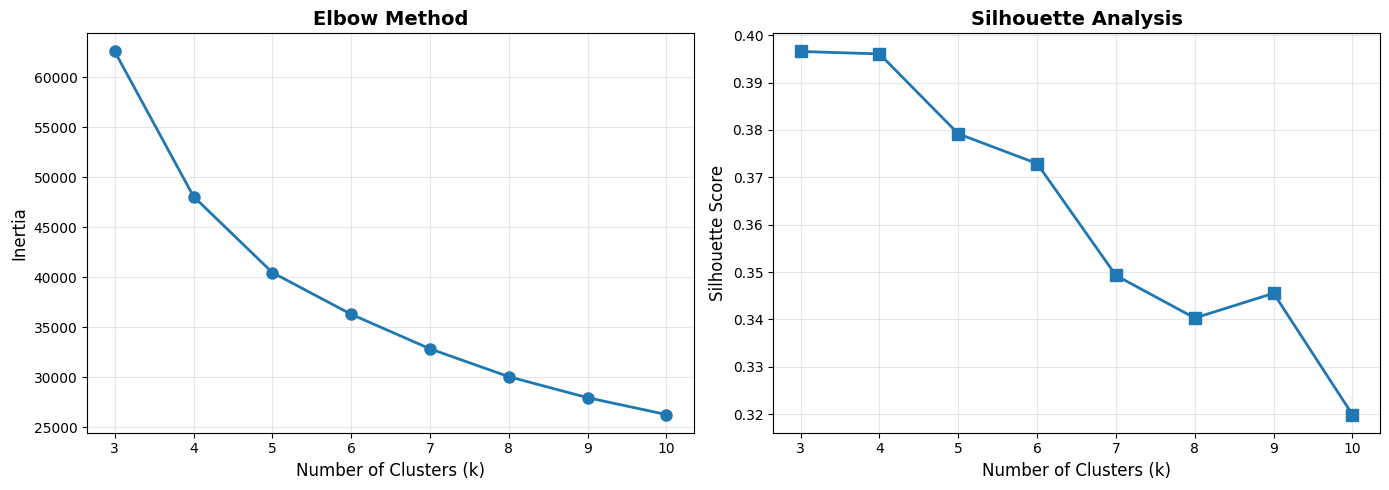

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(k_range, inertias, marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(k_range, silhouette_scores, marker='s', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
# Final clustering with k = 4
optimal_k = 4

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
clusters = kmeans_final.fit_predict(combined_features)

case_features_engineered['cluster'] = clusters

print(f"\nCluster distribution:")
print(case_features_engineered['cluster'].value_counts().sort_index())

print("\nCluster characteristics:")
cluster_summary = case_features_engineered.groupby('cluster').agg({
    'variant_length': 'mean',
    'unique_activities': 'mean',
    'loop_count': 'mean',
    'throughput_days': 'mean',
    'num_events': 'mean',
    'case:concept:name': 'count'
}).round(2)
cluster_summary.columns = ['Avg Length', 'Avg Unique Acts', 'Avg Loops', 
                          'Avg Throughput', 'Avg Events', 'Count']
print(cluster_summary)


Cluster distribution:
cluster
0    11053
1     8469
2     8956
3     3031
Name: count, dtype: int64

Cluster characteristics:
         Avg Length  Avg Unique Acts  Avg Loops  Avg Throughput  Avg Events  \
cluster                                                                       
0             46.27            17.58      28.70           18.70       46.27   
1             23.94            12.52      11.42           33.31       23.94   
2             29.26            14.98      14.28           11.20       29.26   
3             74.56            18.13      56.43           33.29       74.56   

         Count  
cluster         
0        11053  
1         8469  
2         8956  
3         3031  


In [23]:
case_features_engineered['cluster']

0        1
1        2
2        1
3        0
4        0
        ..
31504    0
31505    3
31506    1
31507    2
31508    0
Name: cluster, Length: 31509, dtype: int32


Outcome distribution by cluster (%):
outcome  Approved  Rejected
cluster                    
0            75.0      25.0
1            70.6      29.4
2            71.4      28.6
3            66.9      33.1


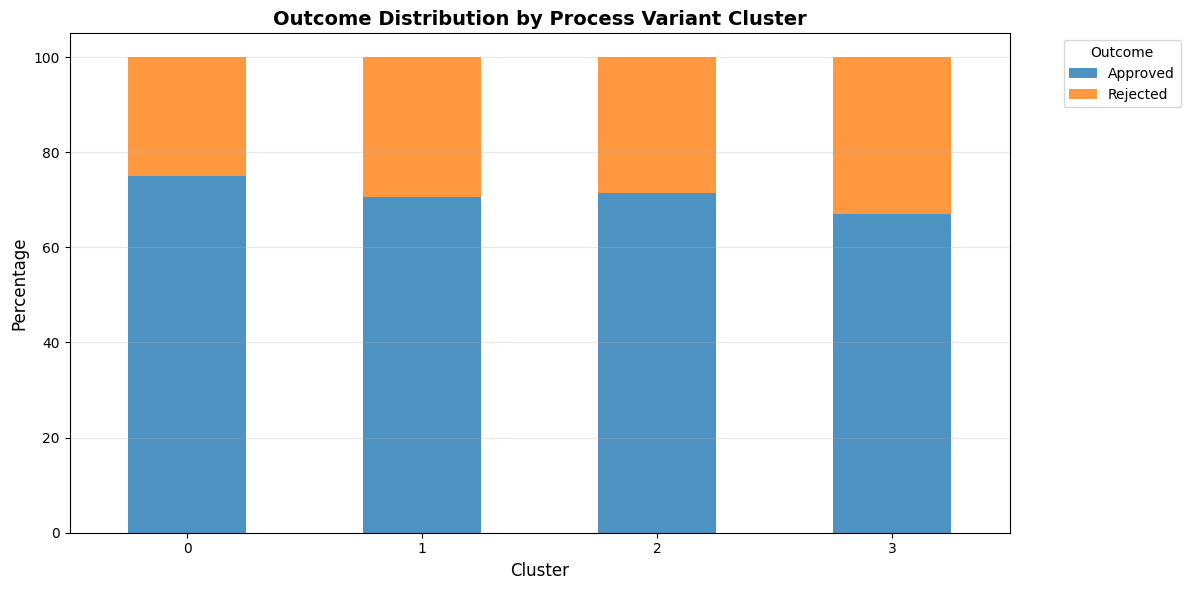

In [ ]:
# Analyze clusters by outcome
outcome_by_cluster = pd.crosstab(
    case_features_engineered['cluster'],
    case_features_engineered['outcome'], 
    normalize='index'
) * 100

print("\nOutcome distribution by cluster (%):")
print(outcome_by_cluster.round(1))

# Visualize
outcome_by_cluster.plot(kind='bar', stacked=True, figsize=(12, 6), alpha=0.8)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.title('Outcome Distribution by Process Variant Cluster', 
         fontsize=14, fontweight='bold')
plt.legend(title='Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()